In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [2]:
class loadDataSet(Dataset):
    
    def __init__(self, root, transform):
        self.image_files = np.array([x.path for x in os.scandir(root) if x.name.endswith(".png")])
        self.transform = transform
        
    def __getitem__(self, index):
        im = Image.open(self.image_files[index]).convert('RGB')
        im = self.transform(im)
        return im

    def __len__(self):
        return len(self.image_files)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)
torch.cuda.set_device(1)

batchSize = 256
reSize = 64
epochs = 1400
dataSet = loadDataSet(root='./cartoon/', transform = transforms.Compose([transforms.Resize(reSize),
                                                   transforms.ToTensor()
#                                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                                                                         std=[0.5, 0.5, 0.5])
                                                                        ]))
dataloader = DataLoader(dataSet, batch_size = batchSize, shuffle = True)
print(len(dataSet),',',len(dataloader))

device = cuda
10000 , 40


In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z) #shape=[256, 32]
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
def loss_fn(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [10]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #0.001

In [11]:
L_total = list()
for epoch in range(epochs):
    L = 0
    for idx, images in enumerate(dataloader):
        recon_images, mu, logvar = model(images.cuda())
        loss, bce, kld = loss_fn(recon_images, images.cuda(), mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        L += loss.item()
    
    L_total.append(L/len(dataloader))
    to_print = "Epoch[{}/{}] Loss: {:.3f} ".format(epoch+1, epochs, L_total[-1])
#     to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, epochs, L/len(dataSet), bce.item()/batchSize, kld.item()/batchSize)
    print(to_print)

/home/kuo/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/1400] Loss: 317505.264 
Epoch[2/1400] Loss: 202237.767 
Epoch[3/1400] Loss: 201843.250 
Epoch[4/1400] Loss: 201794.147 
Epoch[5/1400] Loss: 201782.158 
Epoch[6/1400] Loss: 201777.813 
Epoch[7/1400] Loss: 201775.603 
Epoch[8/1400] Loss: 201774.227 
Epoch[9/1400] Loss: 201773.389 
Epoch[10/1400] Loss: 201773.148 
Epoch[11/1400] Loss: 201772.746 
Epoch[12/1400] Loss: 201772.607 
Epoch[13/1400] Loss: 201772.158 
Epoch[14/1400] Loss: 201772.101 
Epoch[15/1400] Loss: 201771.891 
Epoch[16/1400] Loss: 201771.951 
Epoch[17/1400] Loss: 201772.028 
Epoch[18/1400] Loss: 201771.754 
Epoch[19/1400] Loss: 201771.658 
Epoch[20/1400] Loss: 201771.587 
Epoch[21/1400] Loss: 201771.683 
Epoch[22/1400] Loss: 201771.490 
Epoch[23/1400] Loss: 201771.576 
Epoch[24/1400] Loss: 201771.477 
Epoch[25/1400] Loss: 201771.425 
Epoch[26/1400] Loss: 201771.441 
Epoch[27/1400] Loss: 201771.432 
Epoch[28/1400] Loss: 201771.388 
Epoch[29/1400] Loss: 201771.349 
Epoch[30/1400] Loss: 201771.364 
Epoch[31/1400] Loss

KeyboardInterrupt: 

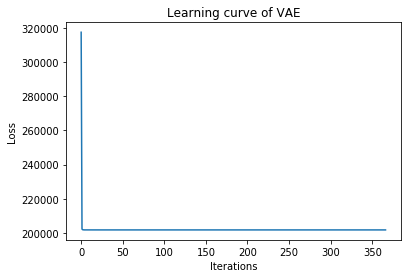

In [12]:
plt.plot(np.array(L_total).reshape(-1, 1))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Learning curve of VAE')
# plt.savefig('1_learningCurve.png')
plt.show()

In [15]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

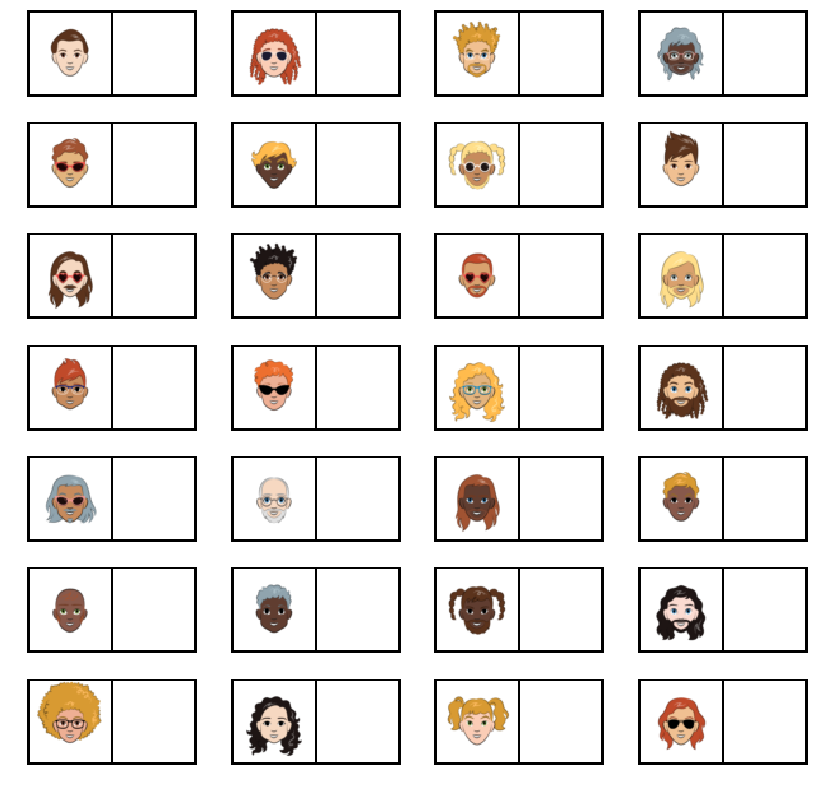

In [16]:
fig = plt.figure(figsize=(14, 14))
row = 7
column = 4
axes = fig.subplots(row, column)

fig_cnt = 0 

idx = np.random.randint(0, 10000, 28)

for i in range(row):
    for j in range(column):
        fixed_x = (dataSet[idx[fig_cnt]]).unsqueeze(0)
        compare_x = compare(fixed_x.cuda())
        save_image(compare_x.data.cpu(), './result/1/' + str(fig_cnt) + '.png')
        
        axes[i, j].imshow(Image.open('./result/1/' + str(fig_cnt) + '.png'), interpolation='nearest')
        axes[i, j].set_axis_off()
        fig_cnt += 1

# plt.savefig('1_example.jpg')
plt.show()
plt.close()

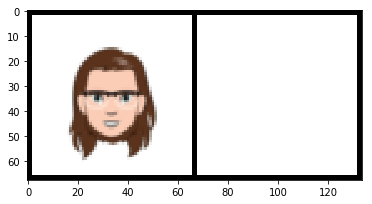

In [17]:
fixed_x = (dataSet[np.random.randint(1, 10000)]).unsqueeze(0)
compare_x = compare(fixed_x.cuda())

save_image(compare_x.data.cpu(), 'sample_image.png')
plt.imshow(Image.open('sample_image.png'))
# display(Image('sample_image.png', width=700, unconfined=True))

In [ ]:
epsilon = torch.randn((256, 1024)).cuda()
z, mu, logvar = model.bottleneck(epsilon)
sample = model.decode(z).cuda()

In [ ]:
save_image(sample.data.cpu(), 'sample_image.png')

In [ ]:
# torch.save(model.state_dict(), 'vae.torch')